In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import (
    MinMaxScaler,
    PowerTransformer,
    RobustScaler
)

# classificador referencial
from sklearn.dummy import DummyClassifier

# estudo linear
from sklearn.linear_model import LogisticRegression

# estudo árvore
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from xgboost import plot_importance

# estudo SVM
from sklearn.svm import SVC

# estudo kNN
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

from src.config import DADOS_TRATADOS
from src.graficos import plot_comparar_metricas_modelos
from src.models_rus import RANDOM_STATE # rus (Random Under Sampler)
from src.models_rus import (
    grid_search_cv_classificador,
    treinar_e_validar_modelo_classificacao,
    organiza_resultados
)

sns.set_theme()

In [2]:
# carregando a base de dados
df = pd.read_parquet(DADOS_TRATADOS)

df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V19,V20,V21,V23,V24,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.403993,0.251412,-0.018307,-0.110474,0.066928,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.145783,-0.069083,-0.225775,0.101288,-0.339846,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-1.232622,-0.208038,-0.108300,-0.190321,-1.175575,-0.221929,0.062723,0.061458,123.50,0
3,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.803487,0.408542,-0.009431,-0.137458,0.141267,0.502292,0.219422,0.215153,69.99,0
4,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.033194,0.084968,-0.208254,-0.026398,-0.371427,0.105915,0.253844,0.081080,3.67,0


In [3]:
# separando as colunas para os pré-processamentos
coluna_min_max = ["Time"] # o tempo vai ter apenas um ajuste de escala para acompanhar as demais features

coluna_power_transformer = ["Amount"] # essa variável teve uma grande distorção após a remoção de outliers

coluna_target = ["Class"] # coluna target

# pegando as colunas exceto diferentes das de cima
colunas_robust_scaler = [ 
    # pegando cada coluna do df que for diferente das informadas
    coluna for coluna in df.columns if coluna not in (
        coluna_min_max + coluna_power_transformer + coluna_target
    )
]

print(colunas_robust_scaler)

['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V23', 'V24', 'V26', 'V27', 'V28']


- Para identificar o tipo de pré-processamento adequado para cada feature é ideal abrir o `01-jb_eda` e visuaizar os boxplots, sem esquecer que cada pré-processamento será realizado na coluna ou colunas por inteiro e não separada por classe. Com isso, devemos entender que a distribuição utilizada será da feature por inteiro.

In [4]:
# separando o X e y
X = df.drop(columns=coluna_target)
y = df[coluna_target].values.ravel() # deixando o y unidimensional, ao invés de bidimensional como dataframe

In [5]:
# pré-processamento
preprocessamento = ColumnTransformer(
    transformers=[
        ("min_max", MinMaxScaler(), coluna_min_max),
        ("robust", RobustScaler(), colunas_robust_scaler),
        ("power_transformer", PowerTransformer(), coluna_power_transformer),
    ]
)

In [6]:
# criando a validação cruzada com estratificação
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

In [7]:
# criando um valor de desbalanceamento para os modelos xgb e lgbm
# scale_pos_weight = np.bincount(y)[0] / np.bincount(y)[1]

# scale_pos_weight

- As classes serão balanceadas para teste, por isso o parâmetro de balanceamento dos pesos da classe minoritária das árvores XGB e LGBM ficarão comentados, porque não terão aplicação após os ajustes realizados.

In [8]:
# classificadores
classificadores = {
    "DummyClassifier": {
        "preprocessor": None,
        "classificador": DummyClassifier(strategy="stratified"),
    },

    
    # modelo linear
    "LogisticRegression": {
        "preprocessor": preprocessamento,
        "classificador": LogisticRegression(class_weight="balanced"), # alguns modelos têm parâmetros para lidar com desbalanceamento
    },

    
    # modelo de árvore
    "DecisionTreeClassifier": {
        "preprocessor": None,
        "classificador": DecisionTreeClassifier(class_weight="balanced"),
    },
    
    "XGBClassifier": {
        "preprocessor": None,
        "classificador": XGBClassifier(
            random_state=RANDOM_STATE,
            # scale_pos_weight=scale_pos_weight, 
            n_jobs=-1
        ),
    },
    
    "LGBMClassifier": {
        "preprocessor": None,
        "classificador": LGBMClassifier(
            random_state=RANDOM_STATE,
            # scale_pos_weight=scale_pos_weight, # aplicando o valor calculado
            n_jobs=-1, 
            verbose=-1
        ),
    },

    # modelo SVM
    "SVR": {
        "preprocessor": preprocessamento,
        "classificador": SVC(class_weight="balanced", cache_size=1000),
    },

    
    # modelo kNN
    "KNeighborsClassifier": {
        "preprocessor": preprocessamento,
        "classificador": KNeighborsClassifier(),
    },
    
}

- Os parâmetros de desbalanceamento darão lugar ao balanceamento, logo os parâmetros de weight="balanced" e class_pos_weight não terão utilizade.

In [9]:
# treinando os modelos e criando um dicionário com as métricas resultantes
resultados = {
    nome_modelo: treinar_e_validar_modelo_classificacao(X, y, kf, **classificador)
    for nome_modelo, classificador in classificadores.items()
}

# transformando o dicionário em dataframe
df_resultados = organiza_resultados(resultados)

df_resultados

,model,fit_time,score_time,test_accuracy,test_balanced_accuracy,test_f1,test_precision,test_recall,test_roc_auc,test_average_precision,time_seconds
0,DummyClassifier,0.039484,0.037419,0.500136,0.535714,0.004347,0.002182,0.571429,0.486285,0.00186,0.076903
1,DummyClassifier,0.057429,0.028772,0.499357,0.509862,0.003955,0.001985,0.520408,0.471545,0.001814,0.086201
2,DummyClassifier,0.0689,0.030065,0.502806,0.496313,0.003749,0.001881,0.489796,0.51516,0.001971,0.098965
3,DummyClassifier,0.058686,0.005001,0.500643,0.512924,0.004042,0.002029,0.525253,0.52241,0.002023,0.063687
4,DummyClassifier,0.049335,0.017792,0.501189,0.538401,0.004434,0.002226,0.575758,0.516823,0.001998,0.067127
5,LogisticRegression,0.503735,0.092047,0.972562,0.935332,0.111111,0.059219,0.897959,0.984227,0.52356,0.595782
6,LogisticRegression,0.451079,0.085669,0.97151,0.960266,0.112864,0.06,0.94898,0.991035,0.687396,0.536748
7,LogisticRegression,0.390963,0.056885,0.972445,0.95055,0.114035,0.060748,0.928571,0.97567,0.754307,0.447848
8,LogisticRegression,0.433395,0.059706,0.976265,0.942743,0.128755,0.069284,0.909091,0.980751,0.516566,0.493102
9,LogisticRegression,0.362579,0.04485,0.978233,0.963892,0.144061,0.077944,0.949495,0.983963,0.689226,0.407429


- No treinamento dos modelos foi incrementada uma nova etapa no pipeline, após o pré-processamento dos dados foi realizada uma redução aleatória dos registros da classe majoritária, deixando as duas classes com a mesma quantidade de registros. Esse balanceamento foi introduzido na busca por melhoria no desempenho do modelo, por meio do uso de uma amostra da classe majoritária com a mesma quantidade de registros da classe minoritária, que tinha 256.000+ registros, mas agora está em 492.

In [10]:
# agrupando o a média do resultado das métricas pelo modelo, ordenando os modelos pela métrica de foco
df_resultados.groupby("model").mean().sort_values("test_average_precision")

,fit_time,score_time,test_accuracy,test_balanced_accuracy,test_f1,test_precision,test_recall,test_roc_auc,test_average_precision,time_seconds
model,,,,,,,,,,
DummyClassifier,0.054767,0.02381,0.500826,0.518643,0.004105,0.002061,0.536529,0.502445,0.001933,0.078576
DecisionTreeClassifier,0.052567,0.02771,0.919592,0.917119,0.042394,0.021707,0.914636,0.917119,0.020017,0.080276
KNeighborsClassifier,0.458968,1.536392,0.975279,0.936868,0.125031,0.067304,0.89831,0.973087,0.259924,1.99536
LogisticRegression,0.42835,0.067832,0.974203,0.950557,0.122165,0.065439,0.926819,0.983129,0.634211,0.496182
SVR,0.44511,1.017555,0.984632,0.929415,0.184334,0.103549,0.873985,0.985339,0.729458,1.462665
LGBMClassifier,0.113148,0.092761,0.973459,0.9522,0.120431,0.064477,0.93086,0.985891,0.738868,0.205909
XGBClassifier,0.106526,0.04622,0.968478,0.95275,0.10331,0.054705,0.936961,0.985594,0.764235,0.152746


- Com o balanceamento das classes, ocorreu uma perca grande de informação, tanto que houve redução nos valores das métricas de teste de precisão para todos os modelos, que em consequência reduziu o valor de F1-score, que se manteve alto devido ao valor do recall, e redução nos valores da área sob a curva precision-recall (AUPRC).

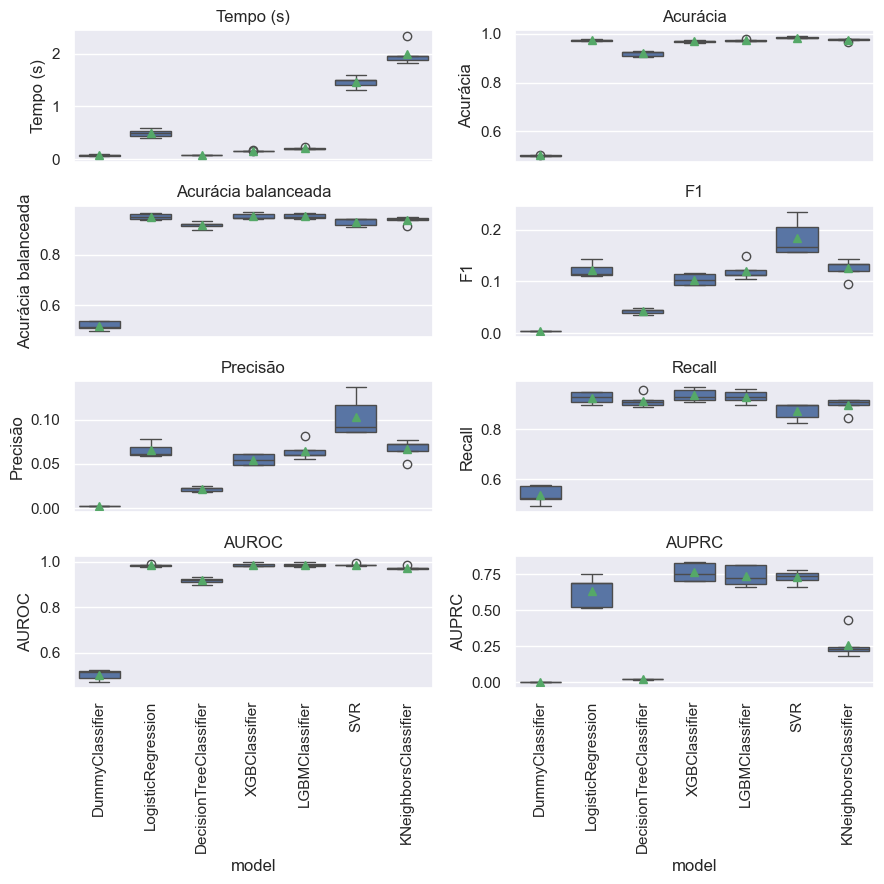

In [11]:
# visualizando graficamente a comparação entre os modelo
plot_comparar_metricas_modelos(df_resultados)

- As métricas tiveram uma queda com o balanceamento das classes, a redução de registros da classe majoritária para equilibrar a quantidade de registros da classe minoritária não retornou um desempenho equilibrado entre recall e precisão. Com isso, a escala das métricas precisão e F1-score ficaram muito baixas.
    - A precisão é a métrica que responde o seguinte questionamento: "Entre todas as transações que o modelo classificou como fraudulenta, quantas são verdadeiramente fraudulentas?"
        - VP / (VP + FP)
    - Enquanto a métrica recall responde o questionamento: "Entre todas as transações que realmente são fraudulentas, quantas o modelo identificou corretamente?"
        - VP / (VP + FN)

In [12]:
# como os classificadores estão em um dicionário, vamos pegar o XGBClassifier
classificadores["XGBClassifier"]

{'preprocessor': None,
 'classificador': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               feature_weights=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=None, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, multi_strategy=None, n_estimators=None,
               n_jobs=-1, num_parallel_tree=None, ...)}

In [13]:
# treinando apenas o XGBClassifier para usar o resultados das métricas como referência
treinar_e_validar_modelo_classificacao(
    X, y, kf, **classificadores["XGBClassifier"]
)

{'fit_time': array([0.09279466, 0.13432097, 0.11410213, 0.09981203, 0.10253835]),
 'score_time': array([0.05927896, 0.05453777, 0.0419066 , 0.04210949, 0.04622388]),
 'test_accuracy': array([0.97340011, 0.96412425, 0.96505963, 0.96876218, 0.97104217]),
 'test_balanced_accuracy': array([0.9408441 , 0.96165869, 0.94685044, 0.94402496, 0.97037087]),
 'test_f1': array([0.11535969, 0.09265648, 0.0921519 , 0.10196078, 0.11442193]),
 'test_precision': array([0.0615917 , 0.04867944, 0.04848162, 0.0539739 , 0.06079797]),
 'test_recall': array([0.90816327, 0.95918367, 0.92857143, 0.91919192, 0.96969697]),
 'test_roc_auc': array([0.98112091, 0.98930711, 0.98074876, 0.98001275, 0.99678068]),
 'test_average_precision': array([0.7009782 , 0.75225609, 0.83117738, 0.70334119, 0.83342021])}

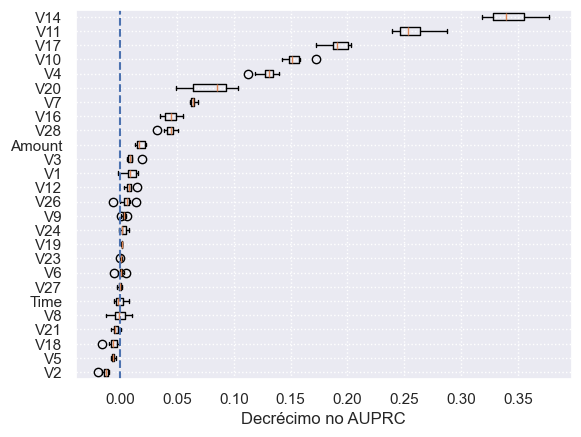

In [14]:
# separando os dados de treino e teste, usando um parâmetro de estratificação devido ao desbalanceamento
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=RANDOM_STATE, stratify=y
)

# pegando o classificador do dicionário de classificadores
clf = classificadores["XGBClassifier"]["classificador"]

# fazendo o treinamento do classificador
clf.fit(X_train, y_train)

# separando a permutação das features
perm_imp = permutation_importance(
    clf, # classificador
    X_test, # X
    y_test, # y
    n_repeats=10, # repetindo a permutação n vezes
    random_state=RANDOM_STATE, # fixando pseudoaleatoriedade
    n_jobs=-1, # usando todos os núcleos do processador
    scoring="average_precision", # métrica de refit
)

# criando um gráfico para exibir a permutação das features de maneira decrescente
fig, ax = plt.subplots()

# ordenando os valores das médias das importâncias das features
ordem = perm_imp.importances_mean.argsort()

# criando boxplots do ordenamento do resultados da permutação de features
ax.boxplot(
    perm_imp.importances[ordem].T, # buscando os valores da importância das features ordenadas
    vert=False, # vertical é falso, porque o boxplot precisa ser horizontal
    tick_labels=X.columns[ordem] # rótulos ordenados
)
ax.axvline(x=0, linestyle="--") # colocando uma linha tracejada para definir o 0
ax.set_xlabel("Decrécimo no AUPRC") # rótulo no eixo x
ax.grid(linestyle=":") # estilo da grade

In [15]:
# verificando os valores médios da permutação
perm_imp.importances_mean

array([-0.00065779,  0.00842619, -0.01292424,  0.00948322,  0.12930448,
       -0.00639937,  0.0003436 ,  0.06401546, -0.00098873,  0.00322513,
        0.1534969 ,  0.25821243,  0.00813552,  0.34193343,  0.04444468,
        0.19166466, -0.0061434 ,  0.00132926,  0.07968752, -0.00401111,
        0.00060667,  0.00289135,  0.00480217, -0.00037529,  0.04370523,
        0.01764042])

In [16]:
# definindo um critério de features com impacto abaixo de 0.01
X.columns[perm_imp.importances_mean < 0.01]

Index(['Time', 'V1', 'V2', 'V3', 'V5', 'V6', 'V8', 'V9', 'V12', 'V18', 'V19',
       'V21', 'V23', 'V24', 'V26', 'V27'],
      dtype='object')

In [17]:
# sobrescrevendo X, removendo as features com importância inferior a 1% na métrica AUPRC
X = X.drop(columns=X.columns[perm_imp.importances_mean < 0.01])

X.columns

Index(['V4', 'V7', 'V10', 'V11', 'V14', 'V16', 'V17', 'V20', 'V28', 'Amount'], dtype='object')

In [18]:
# retreinando o modelo com a nova redução de feature
treinar_e_validar_modelo_classificacao(
    X, y, kf, **classificadores["XGBClassifier"]
)

{'fit_time': array([0.0747149 , 0.09070563, 0.09252191, 0.08043218, 0.06836677]),
 'score_time': array([0.05069733, 0.04784155, 0.08009505, 0.04244781, 0.04433513]),
 'test_accuracy': array([0.96636527, 0.95701146, 0.95765453, 0.95693351, 0.9608699 ]),
 'test_balanced_accuracy': array([0.92204311, 0.94791093, 0.9431408 , 0.94818068, 0.97031565]),
 'test_f1': array([0.09062171, 0.07698745, 0.07728238, 0.07762938, 0.08810173]),
 'test_precision': array([0.04777778, 0.04013962, 0.04031901, 0.04048759, 0.04612458]),
 'test_recall': array([0.87755102, 0.93877551, 0.92857143, 0.93939394, 0.97979798]),
 'test_roc_auc': array([0.9798086 , 0.98620433, 0.9864694 , 0.98050689, 0.99224265]),
 'test_average_precision': array([0.71475609, 0.77579029, 0.77227332, 0.73074236, 0.77023729])}

In [19]:
# grade de parâmetros
param_grid = {
    "clf__max_depth": [6, 10], # profundidade da árvore
    "clf__subsample": [0.6, 0.8, 1.0], # proporção mínima de amostras para cada árvore
    "clf__colsample_bytree": [0.6, 0.8, 1.0], # proporção mínima de features para cada árvore
    "clf__learning_rate": [0.1, 0.3, 0.4], # taxa de aprendizado
    "clf__n_estimators": [100, 200], # número de árvores
    "clf__reg_lambda": [1, 2, 5], # regularização L2
    "clf__reg_alpha": [0, 0.5, 1], # regularização L1
}

In [20]:
# definindo m classificador com alguns parâmetros fixos
clf = XGBClassifier(random_state=RANDOM_STATE, n_jobs=-1)

# busca em grade da melhor combinação de hiperparâmetros
grid_search = grid_search_cv_classificador(
    classificador=clf, # classificador
    param_grid=param_grid, # grade de parâmetros
    cv=kf, # validação cruzada com estratificação
    preprocessor=None, # sem pré-processamento
    refit_metric="average_precision" # métrica de refit
)

grid_search

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('sampler',
                                        RandomUnderSampler(random_state=42)),
                                       ('clf',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_me...
             param_grid={'clf__colsample_bytree': [0.6, 0.8, 1.0],
                         'clf__learning_rate': [0.1, 0.3, 0.4],
                         'clf__max_depth': [6, 10],
                         'clf__n_estimators': [100, 200],
                         'clf__reg_alpha': [0, 0.5, 1],
                         'clf__reg_lambda': [1, 2, 5],
                         'clf__subsample': [0.6, 0.8, 1.0]},
             refit='average_precision',
             scoring=['accuracy', 'balanced_accuracy', 'f1', 'precision',
                      'recall', 'roc_auc', 'average_precision'],
             verbose=1)

In [21]:
# treinando o modelo com a otimização de hiperparâmetros
grid_search.fit(X, y)

Fitting 5 folds for each of 972 candidates, totalling 4860 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('sampler',
                                        RandomUnderSampler(random_state=42)),
                                       ('clf',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_me...
             param_grid={'clf__colsample_bytree': [0.6, 0.8, 1.0],
                         'clf__learning_rate': [0.1, 0.3, 0.4],
                         'clf__max_depth': [6, 10],
                         'clf__n_estimators': [100, 200],
                         'clf__reg_alpha': [0, 0.5, 1],
                         'clf__reg_lambda': [1, 2, 5],
                         'clf__subsample': [0.6, 0.8, 1.0]},
             refit='average_precision',
             scoring=['accuracy', 'balanced_accuracy', 'f1', 'precision',
                      'recall', 'roc_auc', 'average_precision'],
             verbose=1)

In [22]:
# melhores parâmetros do classificador
grid_search.best_params_

{'clf__colsample_bytree': 0.6,
 'clf__learning_rate': 0.3,
 'clf__max_depth': 6,
 'clf__n_estimators': 100,
 'clf__reg_alpha': 0,
 'clf__reg_lambda': 1,
 'clf__subsample': 1.0}

In [23]:
# verificando a métrica de refit
grid_search.best_score_

np.float64(0.7709162524684328)

In [24]:
# verificando os parâmetros do melhor estimador
grid_search.best_estimator_

Pipeline(steps=[('sampler', RandomUnderSampler(random_state=42)),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.3,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=-1,
                               num_parallel_tree=None, ...))])

In [25]:
# verificando as outras métricas de classificação armazenadas na função de grid_search

# verificando cada métrica do resultado que comece com "test"
colunas_test = [coluna for coluna in df_resultados.columns if coluna.startswith("test")]

# colocando o prefixo "mean_" nas colunas_test
colunas_test_mean = ["mean_" + coluna for coluna in colunas_test]

colunas_test_mean

['mean_test_accuracy',
 'mean_test_balanced_accuracy',
 'mean_test_f1',
 'mean_test_precision',
 'mean_test_recall',
 'mean_test_roc_auc',
 'mean_test_average_precision']

In [26]:
# iterando nas colunas_test_mean para exibir a métrica e seu valor
for coluna in colunas_test_mean:
    print(f"{coluna}: {grid_search.cv_results_[coluna][grid_search.best_index_]}")

mean_test_accuracy: 0.9637812767947619
mean_test_balanced_accuracy: 0.9473314297690681
mean_test_f1: 0.09107023328906172
mean_test_precision: 0.047919333371806934
mean_test_recall: 0.9308183879612452
mean_test_roc_auc: 0.9863628023806326
mean_test_average_precision: 0.7709162524684328


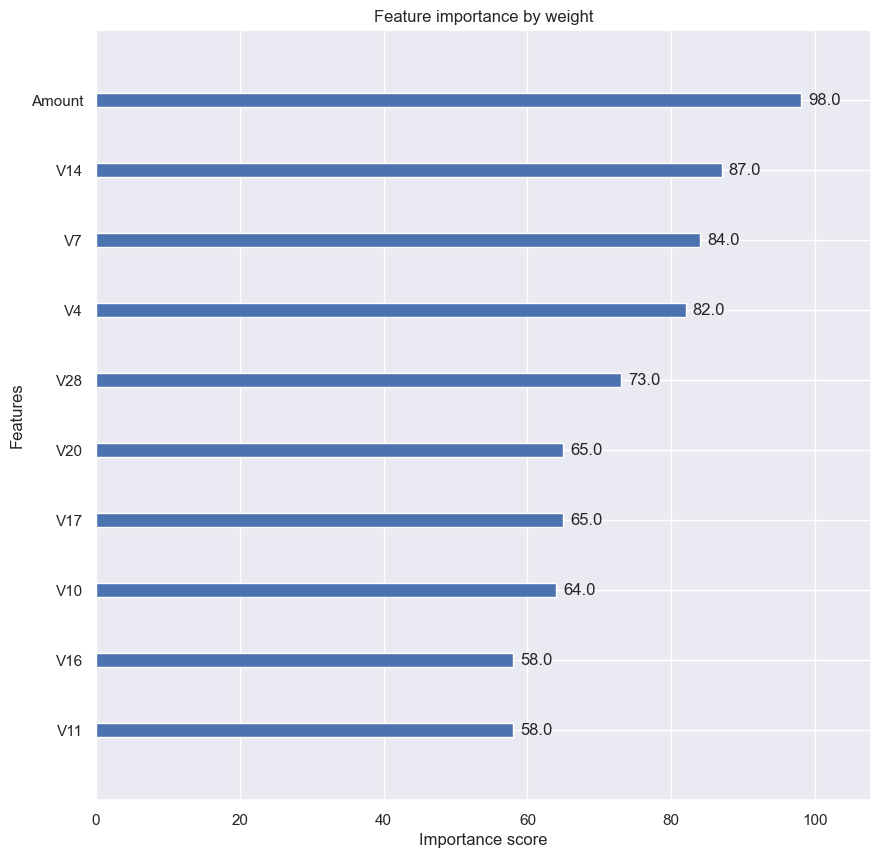

In [27]:
# verificando a importância das features
fig, ax = plt.subplots(figsize=(10,10))

plot_importance(
    grid_search.best_estimator_["clf"],
    ax=ax,
    importance_type="weight", # com base na importância de peso
    title="Feature importance by weight"
)

plt.show()

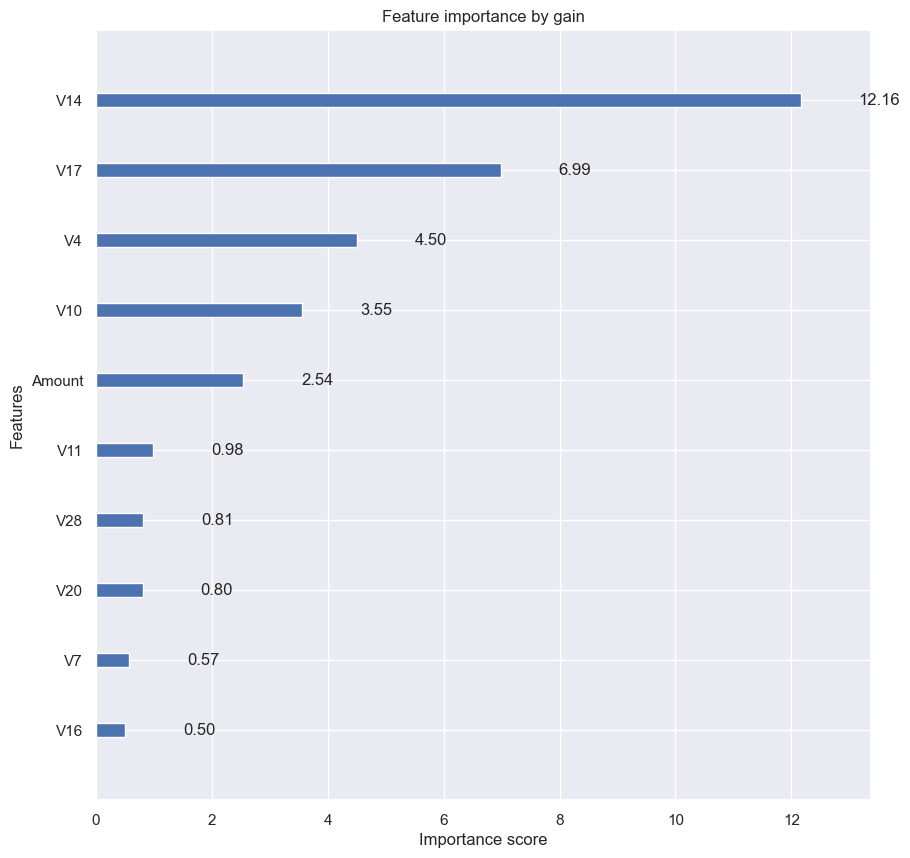

In [28]:
# verificando a importância das features
fig, ax = plt.subplots(figsize=(10,10))

plot_importance(
    grid_search.best_estimator_["clf"],
    ax=ax,
    importance_type="gain", # com base na importância de ganho
    title="Feature importance by gain",
    values_format="{v:.2f}" # formatando para duas casas decimais
)

plt.show()

- Com a redução dos registros para o balanceamento das classes, consequentemente, o resultado da importância das features foi diferente do modelo no notebook anterior.

In [29]:
df["Class"].unique()

array([0, 1])

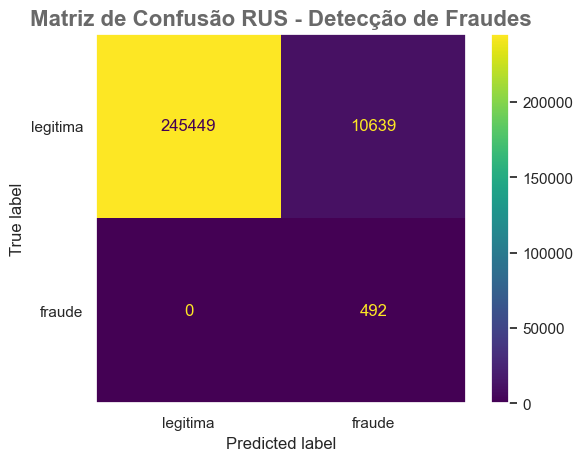

In [32]:
# criando uma matriz de confusão com a quantidade de acertos
ConfusionMatrixDisplay.from_estimator(
    grid_search.best_estimator_, # melhor estimador
    X, 
    y,
    display_labels=["legitima", "fraude"], # nome das classes no target
)

plt.title("Matriz de Confusão RUS - Detecção de Fraudes", fontsize=16, weight="bold", color="dimgrey")

plt.grid(False) # removendo a grade do gráfico

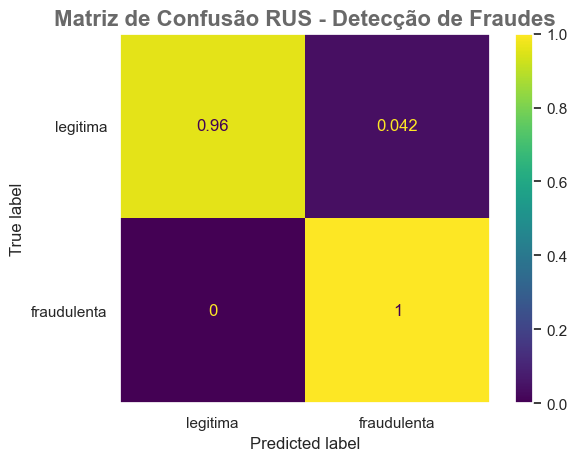

In [33]:
# criando uma matriz de confusão com o percentual de acertos por linha
ConfusionMatrixDisplay.from_estimator(
    grid_search.best_estimator_, # melhor estimador
    X, 
    y,
    display_labels=["legitima", "fraudulenta"], # nome das classes no target
    normalize="true"
)

plt.title("Matriz de Confusão RUS - Detecção de Fraudes", fontsize=16, weight="bold", color="dimgrey")

plt.grid(False) # removendo a grade do gráfico

- O modelo XGBClassifier teve um bom desempenho com as transações fraudulentas, mas errou aproximadamente 10.000 transações legítimas/não fraudulentas. Com a redução aleatória de registros da classe majoritária para equilibrar a quantidade de registros da classe minoritária, o modelo teve um aumento de aproximadamente 909 vezes na quantidade de identificações incorretas de transações fraudulentas que eram verdadeiramente legítimas. A crescente nos erros pode gerar frustração e constrangimento nos clientes que efetuam transações legítimas, podendo receber alertas, bloqueios ou sinalizações de transação fraudulenta, além de um possível gasto financeiro ou operacional para a empresa após essa situação, que pode ser uma perda de clientes pelo inconveniente.